In [1]:
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from pathlib import Path
from operator import itemgetter

from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
import torch.nn.functional as F

from datasets import load_dataset,load_dataset_builder

In [2]:
import torchvision.transforms.functional as TF
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

import logging
logging.disable(logging.WARNING)

## Hugging face datasets

In [3]:
name = "fashion_mnist"

In [4]:
ds_builder = load_dataset_builder(name)
print(ds_builder.info.description)

Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of
60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image,
associated with a label from 10 classes. We intend Fashion-MNIST to serve as a direct drop-in
replacement for the original MNIST dataset for benchmarking machine learning algorithms.
It shares the same image size and structure of training and testing splits.



In [5]:
ds_builder.info.features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(names=['T - shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], id=None)}

In [6]:
ds_builder.info.splits

{'train': SplitInfo(name='train', num_bytes=31296655, num_examples=60000, shard_lengths=None, dataset_name=None),
 'test': SplitInfo(name='test', num_bytes=5233818, num_examples=10000, shard_lengths=None, dataset_name=None)}

In [7]:
dsd = load_dataset(name)
dsd

Extracting data files #1:   0%|          | 0/1 [00:00<?, ?obj/s]

Extracting data files #0:   0%|          | 0/1 [00:00<?, ?obj/s]

Extracting data files #2:   0%|          | 0/1 [00:00<?, ?obj/s]

Extracting data files #3:   0%|          | 0/1 [00:00<?, ?obj/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset fashion_mnist downloaded and prepared to /home/pico/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/8d6c32399aa01613d96e2cbc9b13638f359ef62bb33612b077b4c247f6ef99c1. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [9]:
train, test = dsd['train'], dsd['test']
train[0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
 'label': 9}

In [12]:
x, y = ds_builder.info.features

In [13]:
x, y

('image', 'label')

In [15]:
x, y = 'image', 'label'
img = train[0][x]
img

In [16]:
xb = train[:5][x]
yb = train[:5][y]
yb

[9, 0, 0, 3, 0]

In [17]:
featy = train.features[y]
featy

ClassLabel(names=['T - shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], id=None)

In [19]:
featy.int2str(yb)

['Ankle boot',
 'T - shirt / top',
 'T - shirt / top',
 'Dress',
 'T - shirt / top']

In [24]:
def collate_fn(b):
    #import pdb; pdb.set_trace()
    d = {x:torch.stack( [TF.to_tensor(o[x]) for o in b] ),
        y:tensor([o[y] for o in b])}
    return d

In [25]:
dl = DataLoader(train, collate_fn=collate_fn, batch_size=16)
b = next(iter(dl))
b[x].shape, b[y]

(torch.Size([16, 1, 28, 28]),
 tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9]))

we can use transforms instead of collate_fn because DataLoader also accepts dictionaries (instead of tuples) as inputs :

In [37]:
def transforms(b):
    #import pdb; pdb.set_trace()
    b[x] = [TF.to_tensor(o) for o in b[x]]
    return b

In [38]:
tds = train.with_transform(transforms)
dl = DataLoader(tds, batch_size=16)
b = next(iter(dl))
b[x].shape, b[y]

(torch.Size([16, 1, 28, 28]),
 tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9]))

In [39]:
def _transformi(b): b[x] = [torch.flatten(TF.to_tensor(o)) for o in b[x]]

inplace fuction takes another fuction as an argument ,creates a new function that adds extra fnctionality to the argument function, and then returns the newly created function

In [40]:
def inplace(f):
    def _f(b):
        f(b)
        return b
    return _f

In [41]:
transformi = inplace(_transformi)

In [43]:
# with_transform is applied in _getitem__ dunder
r= train.with_transform(transformi)[0]
r[x].shape, r[y]

(torch.Size([784]), 9)

decorators are the same as transformi = inplace(_transformi)

In [44]:
@inplace
def transformi(b):
    b[x] = [torch.flatten(TF.to_tensor(o)) for o in b[x]]

In [46]:
tdsf = train.with_transform(transformi)
r = tdsf[0]
r[x].shape, r[y]

(torch.Size([784]), 9)

itemgetter returns a function that when called returns a tuple of the elements indexed by the arguments

In [47]:
d = dict(a=1, b=2, c=3)
ig = itemgetter('a', 'c')
ig(d)

(1, 3)

In [53]:
class D:
    def __getitem__(self, k): return 1 if k=='a' else 2 if k=='b' else 3

In [54]:
d = D()
ig(d)

(1, 3)

In [55]:
list(tdsf.features)

['image', 'label']

torch has a default_collate function. With dictionaries, it takes the matching keys, grabs their values and stacks them together

In [57]:
batch = dict(a=[1],b=[2]), dict(a=[3],b=[4])
default_collate(batch)

{'a': [tensor([1, 3])], 'b': [tensor([2, 4])]}

collate_dict returns a function that takes a batch of dictionaries and collates it into a tuple

In [66]:
def collate_dict(ds):
    get = itemgetter(*ds.features)
    def _f(b):
        return get(default_collate(b))
    return _f

In [67]:
dlf = DataLoader(tdsf, batch_size=4, collate_fn=collate_dict(tdsf))
xb, yb = next(iter(dlf))
xb.shape, yb

(torch.Size([4, 784]), tensor([9, 0, 0, 3]))

## Plotting images

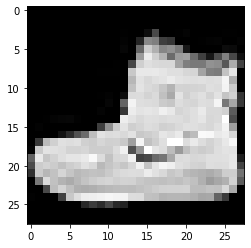

In [69]:
b = next(iter(dl))
xb = b['image']
img = xb[0]
plt.imshow(img[0]);